In [27]:
import drawing_system_dev as ds
import copy
from test_strings import room_sizes, area_types, user_constraints

In [28]:
# Run the processing pipeline
constraints, room_name_mappings = ds.get_constraints_room_mappings(user_constraints, room_sizes)

Constraints: [{'type': 'bedroom_1', 'size': 12}, {'type': 'bedroom_2', 'size': 9}, {'type': 'bedroom_3', 'size': 9}, {'type': 'bedroom_4', 'size': 9}, {'type': 'bathroom_1', 'size': 5}, {'type': 'bathroom_2', 'size': 5}, {'type': 'bathroom_3', 'size': 5}, {'type': 'kitchen_1', 'size': 8}, {'type': 'kitchen_2', 'size': 8}, {'type': 'garage_1', 'size': 6}]
Room Name Mappings: {'bedroom_1': 'bedroom_1', 'bedroom_2': 'bedroom_2', 'bedroom_3': 'bedroom_3', 'bedroom_4': 'bedroom_4', 'bathroom_1': 'bathroom_1', 'bathroom_2': 'bathroom_2', 'bathroom_3': 'bathroom_3', 'kitchen_1': 'kitchen_1', 'kitchen_2': 'kitchen_2', 'garage_1': 'garage_1'}


In [ ]:
grouped_rooms = ds.group_rooms(constraints, area_types)

{'social': [{'name': 'livingroom_1', 'size': 12},
  {'name': 'garage_1', 'size': 6}],
 'service': [{'name': 'kitchen_1', 'size': 8},
  {'name': 'kitchen_2', 'size': 8}],
 'private': [{'name': 'bedroom_1', 'size': 12},
  {'name': 'bedroom_2', 'size': 9},
  {'name': 'bedroom_3', 'size': 9},
  {'name': 'bedroom_4', 'size': 9},
  {'name': 'bathroom_1', 'size': 5},
  {'name': 'bathroom_2', 'size': 5},
  {'name': 'bathroom_3', 'size': 5}]}

In [ ]:
squarified_areas = ds.squarify_areas(grouped_rooms)

[{'x': 0, 'y': 0, 'dx': 38.63636363636364, 'dy': 52.94117647058823},
 {'x': 0,
  'y': 52.94117647058823,
  'dx': 38.63636363636364,
  'dy': 47.05882352941176},
 {'x': 38.63636363636364, 'y': 0, 'dx': 61.36363636363636, 'dy': 100.0}]

In [ ]:
adjacency_requirement = ds.get_adjacency_requirements(user_constraints, room_sizes)

[['bedroom_1', 'kitchen_1'],
 ['bedroom_1', 'bathroom_1'],
 ['bedroom_2', 'livingroom_1'],
 ['bedroom_3', 'livingroom_1'],
 ['bedroom_4', 'livingroom_1'],
 ['bedroom_2', 'bathroom_2'],
 ['bedroom_3', 'bathroom_3'],
 ['garage_1', 'livingroom_1']]

In [32]:
room_data, graph = ds.get_room_data_and_graph(grouped_rooms, squarified_areas)

In [35]:
best_room_data, best_score = ds.optimize_adjacency(room_data, adjacency_requirement)

Trying swap (2, 3): Score = 1
Trying swap (4, 5): Score = 1
Trying swap (6, 7): Score = 1
Trying swap (8, 9): Score = 2
Trying swap (9, 10): Score = 2

✅ Best swap: (8, 9) — New Score: 2
Swapped room 'bathroom_1' with 'bathroom_2'
New positions:
bathroom_1: {'x': 72.10743801652893, 'y': 59.25925925925925, 'dx': 27.892561983471076, 'dy': 20.370370370370367}
bathroom_2: {'x': 72.10743801652893, 'y': 38.888888888888886, 'dx': 27.892561983471076, 'dy': 20.370370370370367}


removed edge: ['livingroom_1', 'garage_1']
removed edge: ['livingroom_1', 'bedroom_1']


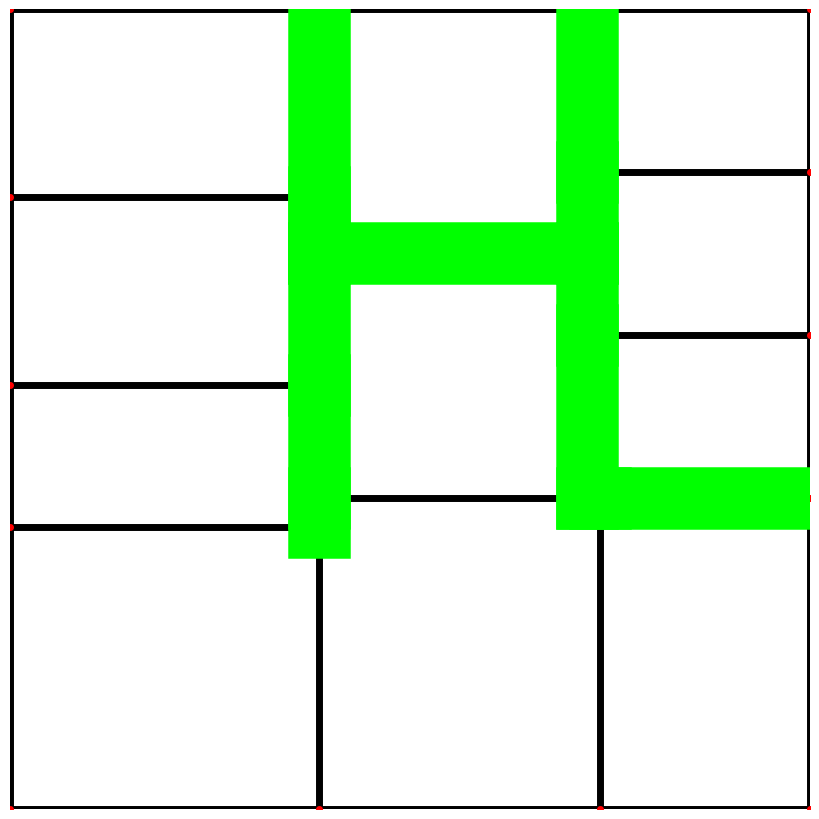

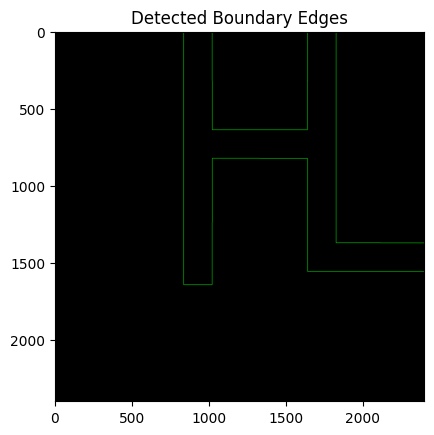

Detected Boundary Edges (as edges): [((834, 0), (834, 1645)), ((834, 1645), (1019, 1645)), ((1019, 1645), (1020, 825)), ((1020, 825), (1638, 826)), ((1638, 826), (1638, 1559)), ((1638, 1559), (2399, 1559)), ((2399, 1559), (2399, 1374)), ((2399, 1374), (1823, 1373)), ((1823, 1373), (1823, 0)), ((1823, 0), (1638, 0)), ((1638, 0), (1637, 640)), ((1637, 640), (1020, 640)), ((1020, 640), (1019, 0)), ((1019, 0), (834, 0))]
Normalized Boundary Edges (100x100 scale):
2
No suitable outside edge found for room 'bedroom_3'
Skipping balcony for room: bedroom_3


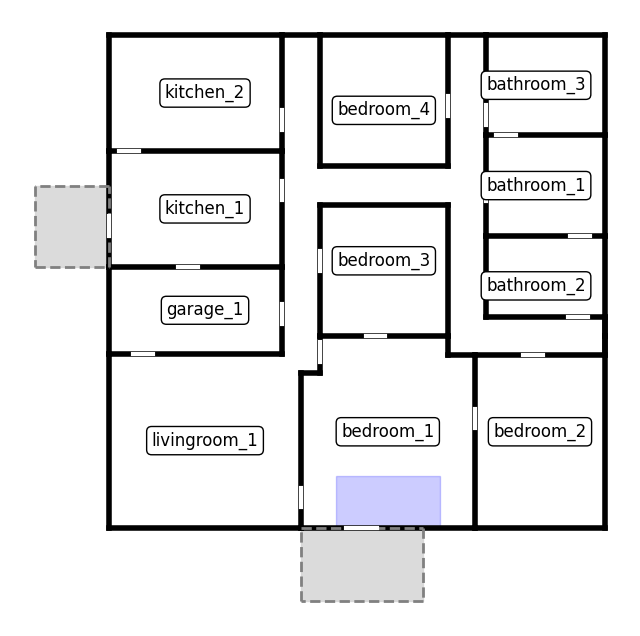

In [39]:
label_positions = ds.get_room_label_positions(best_room_data)
room_data_backbone = copy.deepcopy(best_room_data)
room_data_backbone = ds.convert_to_absolute(room_data_backbone)
graph_data = ds.convert_to_graph_with_room_info(room_data_backbone)
updated_graph_data = ds.remove_outside_edges_and_corners(graph_data)
new_graph, connecting_vertices = ds.remove_room(updated_graph_data, "livingroom_1")

disconnected_rooms = ds.get_disconnected_rooms(best_room_data)
shortest_path_graph = ds.shortest_path_to_connect_rooms(new_graph, connecting_vertices[0][0], disconnected_rooms)
cleaned_path = ds.remove_redundant_edges(shortest_path_graph)
ds.plot_graph_with_path(graph_data, cleaned_path, corridor_width=45, padding=0)
boundary_edges = ds.get_color_boundary_edges(image_path="corridor.png")
normalized_edges = ds.resize_graph_edges(original_graph_edges=boundary_edges, original_size=2400, new_size=100)
merged_normalized_edges = ds.merge_close_values_in_graph(normalized_edges)

corridor_edges_dict = ds.format_corridor_edges(merged_normalized_edges)
merged_edges = {**graph_data['edges'], **corridor_edges_dict}
split_edges_new = ds.split_edges_at_intersections(merged_edges)
unique_edges = ds.remove_duplicate_edges(split_edges_new)
room_edges_in_corridor, corridor_polygon = ds.get_room_edges_within_corridor(merged_normalized_edges, unique_edges)

corridor_edges, room_edges = ds.get_room_and_corridor_edges(unique_edges)
corridor_edges_in_rooms = ds.get_corridor_edges_within_rooms(room_edges, corridor_edges)

updated_edges = ds.remove_given_edges(unique_edges, room_edges_in_corridor)
updated_edges_removed_corridor_from_living_room = ds.remove_corridor_edges_from_living_room(updated_edges, corridor_edges_in_rooms)
room_edges_with_corridor_connection = ds.get_room_edges_with_corridor_connection(corridor_edges_in_rooms, updated_edges_removed_corridor_from_living_room)

door_edges = ds.generate_door_edges(room_edges_with_corridor_connection)

# balconies logic

all_balconies = {}

# Go through all rooms that require balconies
for room_to_add_balcony in user_constraints["floorplan_relationships"]["hasBalcony"]:
    balconies, new_door = ds.add_balcony_to_room(
        room_to_add_balcony,
        room_edges_with_corridor_connection,
        label_positions=label_positions,
        balcony_depth=15
    )

    # Skip if no balcony was created (e.g., edge not found or room center missing)
    if not balconies or not new_door:
        print(f"Skipping balcony for room: {room_to_add_balcony}")
        continue

    all_balconies.update(balconies)
    door_edges.update(new_door)

# attached bathrooms logic
all_attached_bathrooms = {}

# Loop through rooms from user constraints that should have attached bathrooms
for room_with_bath in user_constraints["floorplan_relationships"]["hasAttachedBathroom"]:
    attach_bath_polygons = ds.add_attached_bathroom_to_room(
        room_name=room_with_bath,
        room_edges_dict=room_edges_with_corridor_connection,
        edge_to_rooms=room_edges_with_corridor_connection,  # since it's already in that format
        label_positions=label_positions,
        width_fraction=0.6,  # or customize per room if needed
        depth_fraction=0.3
    )

    if attach_bath_polygons:
        all_attached_bathrooms.update(attach_bath_polygons)

# Generate and save the final floorplan image
save_path = "final_floorplan.png"

# Final plot
ds.plot_graph_edges_with_doors(
    edges_dict=room_edges_with_corridor_connection,
    door_edges=door_edges,
    label_positions=label_positions,
    balconies=all_balconies,
    attached_bathrooms=all_attached_bathrooms,
    save_path=save_path
)

No suitable outside edge found for room 'bedroom_3'
Skipping balcony for room: bedroom_3


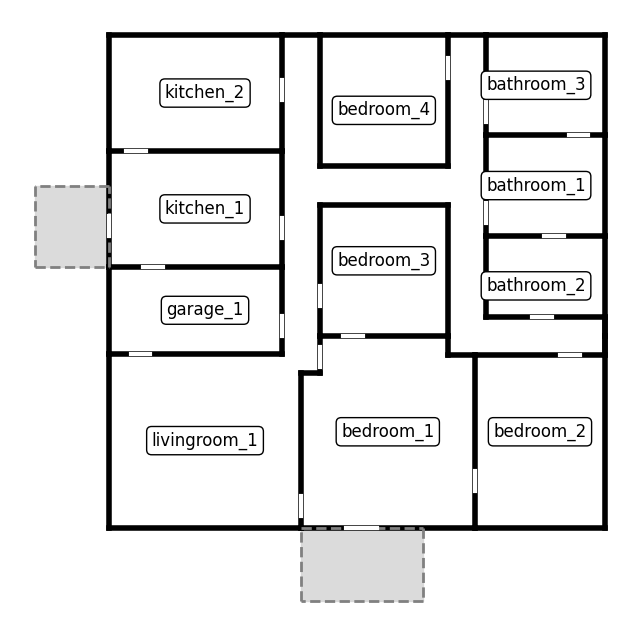

In [ ]:
all_balconies = {}

# Go through all rooms that require balconies
for room_to_add_balcony in user_constraints["floorplan_relationships"]["hasBalcony"]:
    balconies, new_door = ds.add_balcony_to_room(
        room_to_add_balcony,
        room_edges_with_corridor_connection,
        label_positions=label_positions,
        balcony_depth=15
    )

    # Skip if no balcony was created (e.g., edge not found or room center missing)
    if not balconies or not new_door:
        print(f"Skipping balcony for room: {room_to_add_balcony}")
        continue

    all_balconies.update(balconies)
    door_edges.update(new_door)

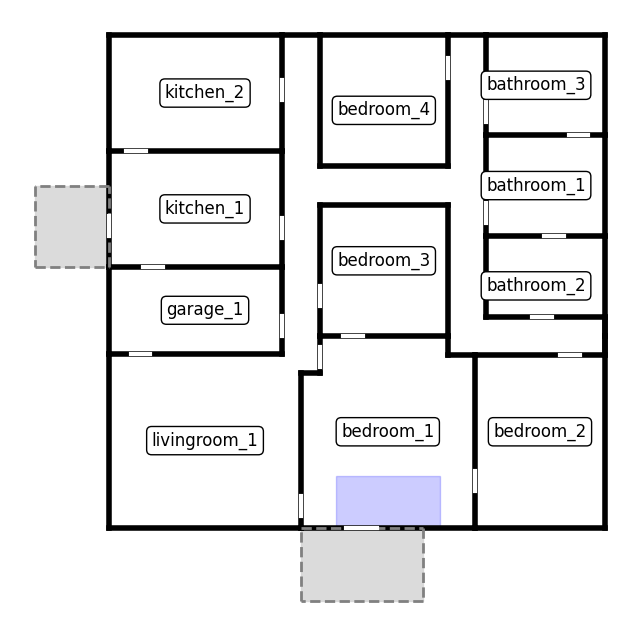

In [14]:
all_attached_bathrooms = {}

# Loop through rooms from user constraints that should have attached bathrooms
for room_with_bath in user_constraints["floorplan_relationships"]["hasAttachedBathroom"]:
    attach_bath_polygons = ds.add_attached_bathroom_to_room(
        room_name=room_with_bath,
        room_edges_dict=room_edges_with_corridor_connection,
        edge_to_rooms=room_edges_with_corridor_connection,  # since it's already in that format
        label_positions=label_positions,
        width_fraction=0.6,  # or customize per room if needed
        depth_fraction=0.3
    )

    if attach_bath_polygons:
        all_attached_bathrooms.update(attach_bath_polygons)

# Final plot
ds.plot_graph_edges_with_doors(
    edges_dict=room_edges_with_corridor_connection,
    door_edges=door_edges,
    label_positions=label_positions,
    balconies=all_balconies,
    attached_bathrooms=all_attached_bathrooms
)
